In [1]:
import sys
import os
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import Model, TVModel, LRModel, BLModel
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups, Upsampling
from graph_deep_decoder.graph_clustering import MultiResGraphClustering, Type_A

DATASET_PATH = '../dataset/temperatures2003_3months_knn16.npz'
MAX_SIGNALS = 100
SEED = 0

n_p = 0.1

plt.rcParams['image.cmap'] = 'Spectral_r'

In [2]:
def create_filter(G, ps, x=None):
    S = np.asarray(G.W.todense())
    if ps['S'] is 'A_norm':
        eigenvalues, _ = np.linalg.eig(S)
        S = S/np.max(np.abs(eigenvalues))
    elif ps['S'] is 'A_D_norm':
        D_inv_sqrt = np.diag(1/np.sqrt(np.sum(S, axis=0)))
        S = D_inv_sqrt.dot(S.dot(D_inv_sqrt))

    if ps['type'] is 'BLH':
        _, V = utils.ordered_eig(S)
        V = np.real(V)
        eigvalues = np.ones(V.shape[0])*0.001
        bl_k = int(G.N*ps['k'])
        if ps['firsts']:
            eigvalues[:bl_k] = 1
        else:          
            x_freq = V.T.dot(x)
            idx = np.flip(np.abs(x_freq).argsort(), axis=0)[:bl_k]
            eigvalues[idx] = 1
            
        H = V.dot(np.diag(eigvalues).dot(V.T))
    elif  ps['type'] is 'RandH':
        hs = np.random.rand(ps['K'])
        hs /= np.sum(hs)
    elif  ps['type'] is 'FixedH':
        hs = ps['hs']
    else:
        print('Unkwown filter type')
        return None

    if ps['type'] is not 'BLH':
        H = np.zeros((S.shape))
        for l, h in enumerate(hs):
            H += h*np.linalg.matrix_power(S,l)
        
    if ps['H_norm']:
            H /= np.linalg.norm(H)
    
    return H

## Load dataset

Dir G: False


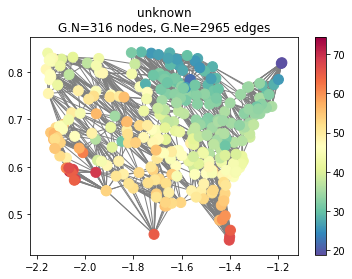

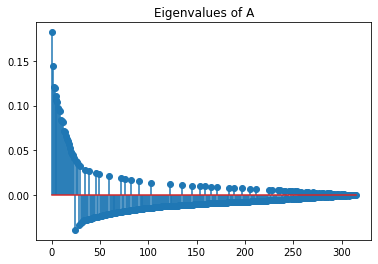

In [3]:
npzfile = np.load(DATASET_PATH)
A = npzfile['A']
A_bin = npzfile['A_bin']
X = npzfile['X']
Coords = npzfile['Coords']
n_signals = np.min([X.shape[1], MAX_SIGNALS])

G = Graph(A)
G.set_coordinates(Coords)
G.plot_signal(X[:, 31])
S = A
L = G.L.todense()

lambdas, _ = utils.ordered_eig(A)
plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of A')

print('Dir G:', G.is_directed(recompute=True))

## Characterize dataset

In [4]:
sm = np.zeros(n_signals)
tv = np.zeros(n_signals)
bl_err_first = np.zeros(n_signals)
bl_err = np.zeros(n_signals)
for i in range(n_signals):
    signal = ds.DeterministicGS(G, X[:, i])
    signal_norm = np.linalg.norm(signal.x)
    signal.to_unit_norm()
    sm[i] = signal.smoothness()
    tv[i] = signal.total_variation()
    bl_err_first[i] = signal.check_bl_err(coefs=0.25, firsts=True)
    bl_err[i] = signal.check_bl_err(coefs=0.25, firsts=False)

print('Mean: SM: {} TV: {} BL Err: {} ({}) N: {}'
      .format(np.mean(sm), np.mean(tv), np.mean(bl_err_first),
              np.mean(bl_err), G.N))

Mean: SM: 0.0026382879875686297 TV: 5.890259189445781 BL Err: 0.018329981329096464 (0.006991927647148601) N: 316


## Denoising - pn .1

#### Choosing hyperparameters

In [5]:
torch.manual_seed(SEED)
np.random.seed(SEED)

Exps = [{'type': 'TV', 'alpha': 10},
        {'type': 'TV', 'alpha': 1},
        {'type': 'TV', 'alpha': 0.1},
        {'type': 'TV', 'alpha': 0.01},
        {'type': 'LR', 'alpha': 100},
        {'type': 'LR', 'alpha': 10},
        {'type': 'LR', 'alpha': 1},
        {'type': 'LR', 'alpha': 0.1},
        {'type': 'BL', 'alpha': .05, 'max_coefs': False},
        {'type': 'BL', 'alpha': .1, 'max_coefs': False},
        {'type': 'BL', 'alpha': .25, 'max_coefs': False},
        {'type': 'BL', 'alpha': .5, 'max_coefs': False}]

err_non_train = np.zeros((len(Exps), n_signals))
start_time = time.time()
for i in range(n_signals):
    _, V = utils.ordered_eig(A)
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)    
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(A, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        else:
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        model.fit(x_n)
        _, err_non_train[j, i] = model.test(x)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

med_err = np.median(err_non_train, axis=1)
for i, exp in enumerate(Exps):
    print('{}-{}: {}'.format(exp['type'], exp['alpha'], med_err[i]))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 0.6695493261019388 minutes ---
TV-10: 0.3107598486979357
TV-1: 0.04734955130883759
TV-0.1: 0.08147291810603342
TV-0.01: 0.09604159446964272
LR-100: 0.032379736178542694
LR-10: 0.028191561181900547
LR-1: 0.0786759878999127
LR-0.1: 0.09570814969406072
BL-0.05: 0.037901023601219525
BL-0.1: 0.034608342532674384
BL-0.25: 0.042264675801114183
BL-0.5: 0.05866540618493031


#### Choose best 2LD model

#### Choose best 2LD model

Text(0.5, 1.0, 'Eigenvalues of H_norm')

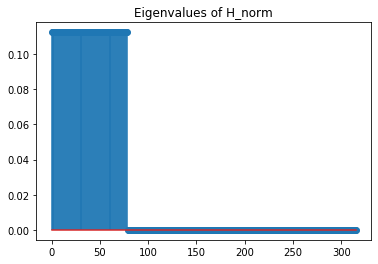

In [6]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 500
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.25, 'H_norm': True}
H = create_filter(G, h_params)

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
        
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': '2LD', 'fts': 500, 'std': .1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': '2LD', 'fts': 500, 'std': .01, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        
        {'type': '2LD', 'fts': 1500, 'std': 1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': '2LD', 'fts': 1500, 'std': .1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': '2LD', 'fts': 1500, 'std': .01, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        ]

lambdas, _ = utils.ordered_eig(H)
plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of H_norm')

In [7]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 61.492870048681894 minutes ---


Min err:
	Model 1: 0.02819156118190054
	Model 2: 0.034608342532674384
	Model 3: 0.03968991561071711
	Model 6: 0.04072064611386317
	Model 4: 0.0419447044776545
	Model 5: 0.0422606147364073
	Model 7: 0.042647945194426384
	Model 8: 0.04286793101176059
	Model 0: 0.04734955130883759


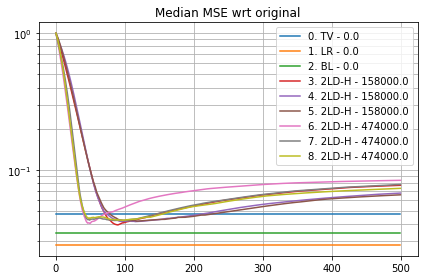

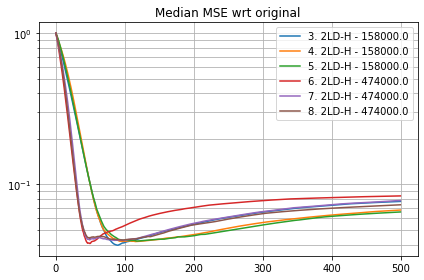

In [8]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(med_mse[3:].T)
plt.grid(True, which='both')
plt.legend(legend[3:])
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

#### Choose best Deep Decoder-H

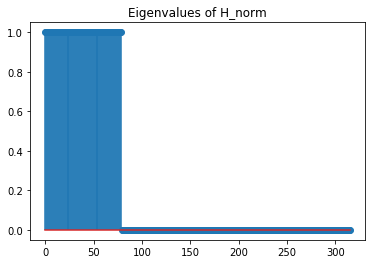

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 500
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.25, 'H_norm': False}
H = create_filter(G, h_params)
H_norm = H/np.linalg.norm(H)

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},

        # Weights
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [50]*3 + [1], 'bn': False, # second best
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,  # best
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [150]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        
        # Init
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 2, 'H_norm': False,
         'legend': 'DeepD-H'},
        
        # Layers --> before std=1
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*6, 'fts': [54]*5 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*8, 'fts': [44]*7 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        ]

lambdas, _ = utils.ordered_eig(H)
plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of H_norm')


for exp in Exps:
    if exp['type'] is 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [10]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 29.900734388828276 minutes ---


Min err:
	Model 1: 0.02819156118190054
	Model 2: 0.034608342532674384
	Model 8: 0.03701999392123412
	Model 4: 0.03707319346151827
	Model 3: 0.038366366045231415
	Model 6: 0.039056349362843135
	Model 9: 0.03928474607771132
	Model 5: 0.04018881859572572
	Model 7: 0.0433940053315164
	Model 0: 0.04734955130883759


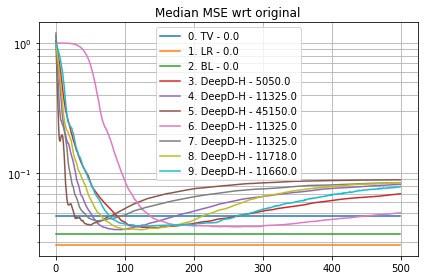

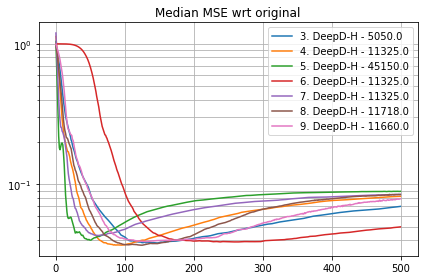

In [11]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(med_mse[3:].T)
plt.grid(True, which='both')
plt.legend(legend[3:])
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

#### Choose best Deep Decoder-U  bn

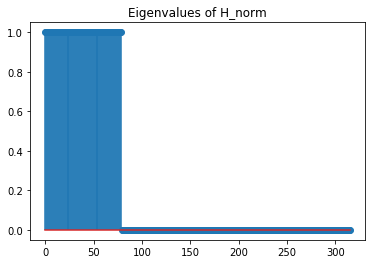

In [12]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 1000
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.25, 'H_norm': False}
H = create_filter(G, h_params)
H_norm = H/np.linalg.norm(H)

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
    
        # Original
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U'},
        # Upsampling sizes
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [10, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U'},
        # Layers
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 100] + [G.N]*2, 'fts': [62]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U'},
        # GF
        {'type': 'DD', 'ups': Ups.GF, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .01, 'in_std': .01, 'bn': True, 'K': 3,
         'legend': 'DeepD-U'},
        # Weigths
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [75]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [8]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U'},
        
        # Init
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .001, 'bn': True, 'K': None,
         'legend': 'DeepD-U'},
        ]

lambdas, _ = utils.ordered_eig(H)
plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of H_norm')


for exp in Exps:
    if exp['type'] is 'DD' and exp['ups'] in [Ups.U_MEAN, Ups.GF]:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As

In [13]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'], K=exp['K'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 56.70678098599116 minutes ---


Min err:
	Model 5: 0.02100174203555627
	Model 7: 0.021535543021331982
	Model 3: 0.021615910269450644
	Model 4: 0.02555660127501369
	Model 6: 0.027446802387340874
	Model 1: 0.02819156118190054
	Model 9: 0.02842595146818727
	Model 2: 0.034608342532674384
	Model 0: 0.04734955130883759
	Model 8: 0.05003821538365705


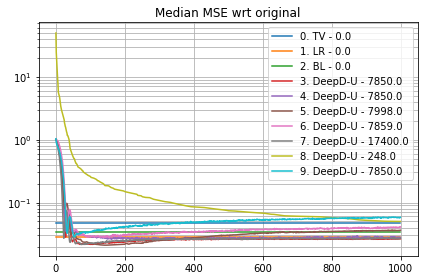

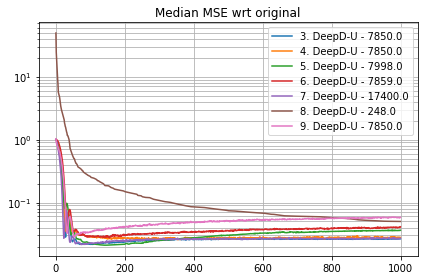

In [14]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(med_mse[3:].T)
plt.grid(True, which='both')
plt.legend(legend[3:])
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

#### Choose best Deep Decoder-U no bn

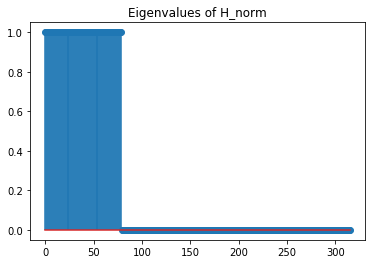

In [15]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 1000
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.25, 'H_norm': False}
H = create_filter(G, h_params)
H_norm = H/np.linalg.norm(H)


Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
    
        # Original
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        # Upsampling sizes
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [10, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        # Layers
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 100] + [G.N]*2, 'fts': [62]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        # GF
        {'type': 'DD', 'ups': Ups.GF, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': 3,
         'legend': 'DeepD-U'},
        # Weigths
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [75]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [8]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        # Init
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .01, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        ]

lambdas, _ = utils.ordered_eig(H)
plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of H_norm')


for exp in Exps:
    if exp['type'] is 'DD' and exp['ups'] in [Ups.U_MEAN, Ups.GF]:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As

In [16]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'], K=exp['K'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 37.53334368467331 minutes ---


Min err:
	Model 7: 0.020110734152178678
	Model 3: 0.020506899889575228
	Model 5: 0.02067733626761903
	Model 9: 0.02209329199251489
	Model 4: 0.024596845830576006
	Model 6: 0.02787018741640429
	Model 1: 0.02819156118190054
	Model 8: 0.02957851793717836
	Model 2: 0.034608342532674384
	Model 0: 0.04734955130883759


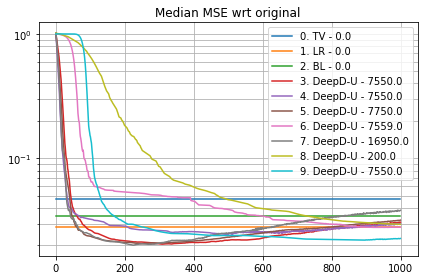

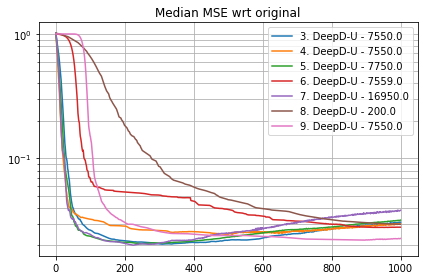

In [17]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(med_mse[3:].T)
plt.grid(True, which='both')
plt.legend(legend[3:])
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

#### Choose best filter BL H

In [18]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 1000
lr = 0.001

Exps = [{'type': 'BL', 'alpha': .1, 'legend': 'BL'},
        {'type': 'BL', 'alpha': .15, 'legend': 'BL'},
        {'type': 'BL', 'alpha': .25, 'legend': 'BL'},
        
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}},
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.15, 'H_norm': False}},
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.2, 'H_norm': False}},
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.25, 'H_norm': False}},
        
        
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.15, 'H_norm': False},
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.2, 'H_norm': False},
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.25, 'H_norm': False},
         'legend': 'DeepD-H'},
        ]       

In [19]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
            continue
        
        H = create_filter(G, exp['h_params'])
        H_norm = H/np.linalg.norm(H)
        if exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], H_norm, exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            Us = [H_norm] if exp['H_norm'] else [H]
            Us = Us*(len(exp['nodes'])-2) + [None] 
            As = []
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], Us, batch_norm=exp['bn'],
                                   As=As, act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()

        model = Model(dec, epochs=epochs, learning_rate=lr)
        _, err[j, i, :], _ = model.fit(x_n, x)
            
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 55.08452846606573 minutes ---


Min err:
	Model 3: 0.02679046951428156
	Model 7: 0.02714158030382907
	Model 8: 0.029431249814766414
	Model 4: 0.030721977847122384
	Model 9: 0.032998755367987354
	Model 0: 0.034608342532674384
	Model 5: 0.03483349413218573
	Model 1: 0.035247409117069764
	Model 10: 0.03753204904629848
	Model 6: 0.04049076803782525
	Model 2: 0.0422646758011142


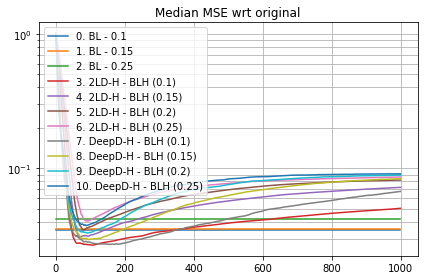

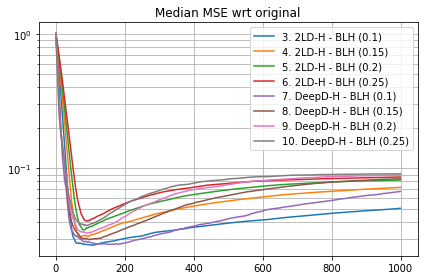

In [20]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    if exp['type'] is 'BL':
        legend.append('{}. {} - {}'.format(i, exp['legend'], exp['alpha']))
        continue
    h_params =  exp['h_params']
    legend.append('{}. {} - {} ({})'.
                  format(i, exp['legend'], h_params['type'], h_params['k']))
        
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(med_mse[3:].T)
plt.grid(True, which='both')
plt.legend(legend[3:])
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

#### Choose best filter H

In [21]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 1000
lr = 0.001

Exps = [{'type': 'BL', 'alpha': .1, 'legend': 'BL'},
        
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}},
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': False, 'k': 0.1, 'H_norm': False}},
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.34, 0.33, 0.33], 'H_norm': False}},
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'legend': '2LD-H',
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [-.5, 0.25, 0.15, 0.1], 'H_norm': False}},
        
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False},
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'BLH', 'S': 'A', 'firsts': False, 'k': 0.1, 'H_norm': False},
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.34, 0.33, 0.33], 'H_norm': False},
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [-.5, 0.25, 0.15, 0.1], 'H_norm': False},
         'legend': 'DeepD-H'},

        ]       

In [22]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
            continue
        
        H = create_filter(G, exp['h_params'], x_n)
        H_norm = H/np.linalg.norm(H)
        if exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], H_norm, exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            Us = [H_norm] if exp['H_norm'] else [H]
            Us = Us*(len(exp['nodes'])-2) + [None] 
            As = []
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], Us, batch_norm=exp['bn'],
                                   As=As, act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()

        model = Model(dec, epochs=epochs, learning_rate=lr)
        _, err[j, i, :], _ = model.fit(x_n, x)
            
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 64.36515023310979 minutes ---


Min err:
	Model 1: 0.02679046951428156
	Model 5: 0.02714158030382907
	Model 0: 0.034608342532674384
	Model 6: 0.04711049741352863
	Model 2: 0.04754312858344356
	Model 7: 0.06619732939067147
	Model 3: 0.06736929929044266
	Model 8: 0.07709300118907692
	Model 4: 0.07976037377911371


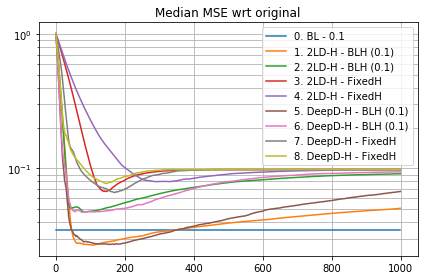

In [23]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    if exp['type'] is 'BL':
        legend.append('{}. {} - {}'.format(i, exp['legend'], exp['alpha']))
        continue
    h_params =  exp['h_params']
    if h_params['type'] is 'BLH':
        legend.append('{}. {} - {} ({})'.
                      format(i, exp['legend'], h_params['type'], h_params['k']))
    else:
        legend.append('{}. {} - {}'.format(i, exp['legend'], h_params['type']))

# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

### Compare denoising models

In [24]:
torch.manual_seed(SEED)
np.random.seed(SEED)

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
        
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U no bn'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [75]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U bn'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [10]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [8]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        ]

# Model parameters
epochs = 750
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
H = create_filter(G, h_params)
H_norm = H/np.linalg.norm(H)

for exp in Exps:
    if exp['type'] is '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] is 'DD' and exp['ups'] is Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] is 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [25]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 52.26627459526062 minutes ---


Min err:
	Model 5: 0.01984619732875803
	Model 6: 0.021447729736456894
	Model 4: 0.026286929123526148
	Model 3: 0.026986381891426214
	Model 1: 0.02819156118190054
	Model 8: 0.03275887284731188
	Model 2: 0.034608342532674384
	Model 7: 0.045378385063253646
	Model 0: 0.04734955130883759


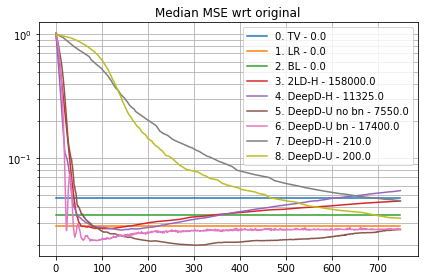

In [26]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

### Compare denoising models without normalizing X

In [27]:
torch.manual_seed(SEED)
np.random.seed(SEED)

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
        
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U no bn'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [75]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U bn'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [10]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [8]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        ]

# Model parameters
epochs = 750
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
H = create_filter(G, h_params)
H_norm = H/np.linalg.norm(H)

for exp in Exps:
    if exp['type'] is '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] is 'DD' and exp['ups'] is Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] is 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [28]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err_aux, _ = model.fit(x_n, x)
            err[j, i, :] = err_aux/np.linalg.norm(x)**2
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train/np.linalg.norm(x)**2, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 31.173300123214723 minutes ---


Min err:
	Model 5: 0.01984619732875803
	Model 6: 0.021447729736456894
	Model 4: 0.026286929123526148
	Model 3: 0.026986381891426214
	Model 1: 0.02819156118190054
	Model 8: 0.03275887284731188
	Model 2: 0.034608342532674384
	Model 7: 0.045378385063253646
	Model 0: 0.04734955130883759


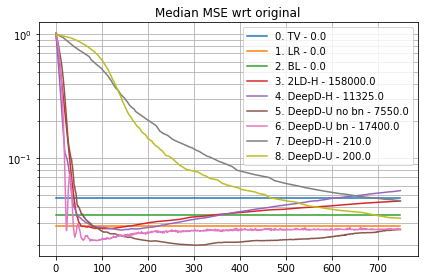

In [29]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

## Denoising - pn .3

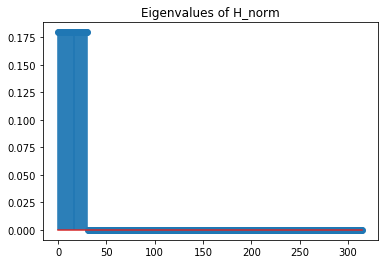

In [30]:
torch.manual_seed(SEED)
np.random.seed(SEED)

n_p = 0.3

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 10, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
        
        {'type': '2LD', 'fts': 500, 'std': 1, 'H_norm': True, 'H': H, 'legend': '2LD-H'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,  # best
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U no bn'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [75]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .00001, 'bn': True, 'K': None,
         'legend': 'DeepD-U bn'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [10]*3 + [1], 'bn': False,  # best
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'DeepD-H'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [8]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        ]


# Model parameters
epochs = 750
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': True}
H = create_filter(G, h_params)
H_norm = H/np.linalg.norm(H)


lambdas, _ = utils.ordered_eig(H)
plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of H_norm')


for exp in Exps:
    if exp['type'] is '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] is 'DD' and exp['ups'] is Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] is 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [31]:
err = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = X[:, i]
    x /= np.linalg.norm(x)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] is 'TV':
            model = TVModel(S, exp['alpha'])
        elif exp['type'] is 'LR':
            model = LRModel(L, exp['alpha'])
        elif exp['type'] is 'BL':
            _, V = utils.ordered_eig(S)
            k = int(G.N*exp['alpha'])
            model = BLModel(V, k)
        elif exp['type'] is '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] is 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            _, err[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
--- 52.36067175467809 minutes ---


Min err:
	Model 5: 0.03264093440719407
	Model 6: 0.036535522008354984
	Model 8: 0.04122851585917861
	Model 3: 0.05107317855865423
	Model 4: 0.051628856089481756
	Model 2: 0.05327227157522713
	Model 1: 0.0745272065843311
	Model 0: 0.09800249995267862
	Model 7: 0.14088674375990817


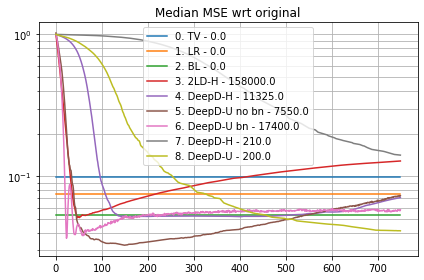

In [32]:
# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(med_mse, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

In [33]:
plt.show()